# Fake News Detection

We're going to train a model to be able to detect fake news based on their headlines and content.

Inspiration and help taken from: https://www.geeksforgeeks.org/fake-news-detection-using-machine-learning/

### Import and Install Dependencies

In [22]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amudha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amudha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/amudha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### View and Preprocess Data

In [2]:
# Read csv file as a dataframe with pandas
df = pd.read_csv('./fake-news/train.csv',header=None)
df

,0,1,2,3,4
0,id,title,author,text,label
1,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
2,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
3,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
4,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
...,...,...,...,...,...
20796,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20797,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20798,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20799,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [3]:
# Cleaning up the data
df = df.drop(0)
df.drop([0,1,2], axis=1, inplace=True)
df.rename(columns={1: 'title', 3: 'text', 4: 'label'}, inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df

,text,label
1,House Dem Aide: We Didn’t Even See Comey’s Let...,1
2,Ever get the feeling your life circles the rou...,0
3,"Why the Truth Might Get You Fired October 29, ...",1
4,Videos 15 Civilians Killed In Single US Airstr...,1
5,Print \nAn Iranian woman has been sentenced to...,1
...,...,...
20796,Rapper T. I. unloaded on black celebrities who...,0
20797,When the Green Bay Packers lost to the Washing...,0
20798,The Macy’s of today grew from the union of sev...,0
20799,"NATO, Russia To Hold Parallel Exercises In Bal...",1


### Visualizing the Data

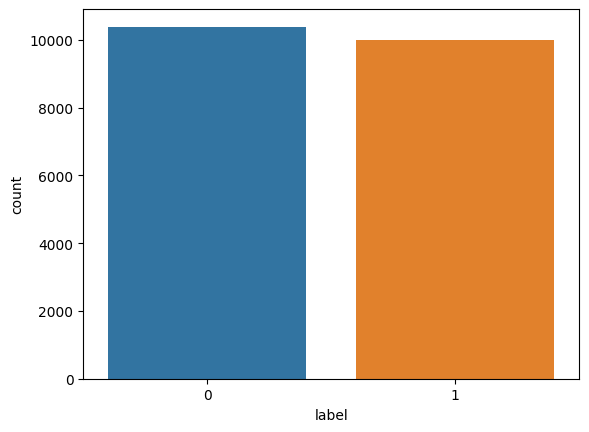

In [4]:
# Count of the unique values in each category
sns.countplot(data=df,
              x='label',
              order=df['label'].value_counts().index)
plt.show()

In [5]:
df['text']

1        House Dem Aide: We Didn’t Even See Comey’s Let...
2        Ever get the feeling your life circles the rou...
3        Why the Truth Might Get You Fired October 29, ...
4        Videos 15 Civilians Killed In Single US Airstr...
5        Print \nAn Iranian woman has been sentenced to...
                               ...                        
20796    Rapper T. I. unloaded on black celebrities who...
20797    When the Green Bay Packers lost to the Washing...
20798    The Macy’s of today grew from the union of sev...
20799    NATO, Russia To Hold Parallel Exercises In Bal...
20800      David Swanson is an author, activist, journa...
Name: text, Length: 20386, dtype: object

### Removing punctuation, Lowercasing, Alphanumerics, Stemming, and Lemmatization

In [6]:
def preprocess_text(text_data):
    stop_words = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        words = [word.lower() for word in sentence.split() if word.isalpha() and word.lower() not in stop_words]
        words = [stemmer.stem(word) for word in words]
        words = [lemmatizer.lemmatize(word) for word in words]
        preprocessed_text.append(' '.join(words))
    return preprocessed_text

df['text'] = preprocess_text(df['text'].values)

100%|████████████████████████████████████| 20386/20386 [03:00<00:00, 112.72it/s]


### Visualizing the Data Pt. 2

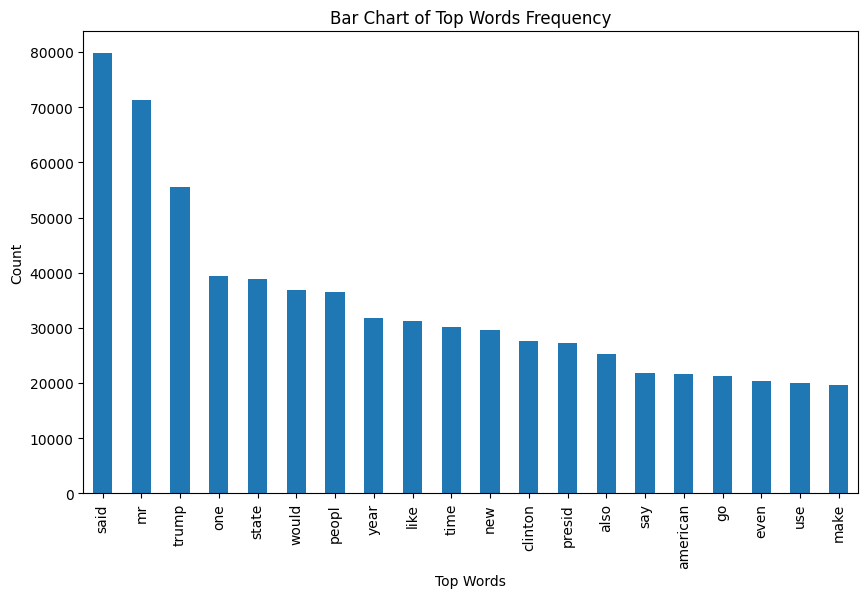

In [7]:
# Display the top 20 words found in our articles
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)
plt.show()

It's interesting to note that as a result of our preprocessing, many of the words have been modified, perhaps in ways that may not be entirely beneficial to us. For example, looking at the top 20 words, ones like "peopl" and "presid" were presumably "people" and "president" but now their meanings have been altered. In the case of a word like "president" now that it has been reduced to "presid" the model might assume it to be the same as words such as "preside" and "presidium" which in reality have entirely different meanings in the English language.

### Machine Learning

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.20, random_state=42)

In [11]:
# Since we are dealing with words, they must be vectorized in order for the model to be fitted to the data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

We will now use logistic regression to make our predictions. This is especially helpful for binary classification tasks, such as this one, since it outputs probability values between 0 and 1. This makes it ideal for predicting whether an article spreads fake news or not.

In [19]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='1')
recall = recall_score(y_test, y_pred, pos_label='1')
f1 = f1_score(y_test, y_pred, pos_label='1')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.9364884747425208
Precision: 0.9348791317217563
Recall: 0.9371909000989119
F1-Score: 0.9360335885403803


Accuracy: How the model does overall, the proportion of classifications that were correct over all classifications

Precision: Proportion of all of the model's positive classifications that were actually positive

Recall: Also known as the true positive rate, the proportion of correctly classified actual positives over all actual positives

F1-Score: Provides a balanced measure of the model's precision and recall (average rate of change, or harmonic mean)

### Analyzing Model Accuracy

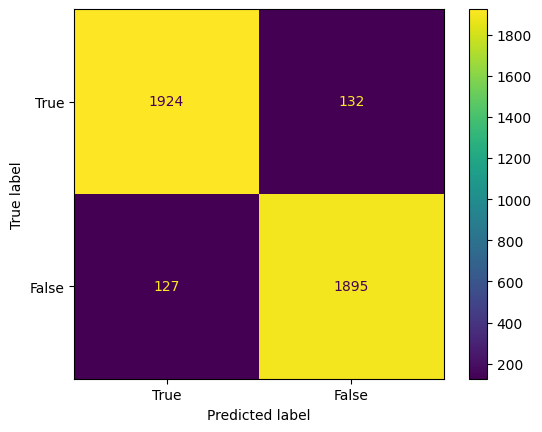

In [23]:
cm = metrics.confusion_matrix(y_test, model.predict(X_test_tfidf))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[True, False])
cm_display.plot()
plt.show()

For future analyses, the model can be improved to make further accurate predictions. It missed 127 articles that were fake, and mistakenly labeled 132 articles as fake when in reality they were true. However, as we see above given the large dataset, it is still able to correctly determine if a piece of news is fake with great accuracy. 